<a href="https://colab.research.google.com/github/lucapqg/Deep-learning/blob/main/deteccao-tumores-tensorflow/detec%C3%A7%C3%A3o_tumores_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Library**

In [139]:
import os
from PIL import Image
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use("dark_background")
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## **Preprocessing**

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
data_dir = '/content/drive/MyDrive/GitHub/deteccao-tumores-tensorflow/Dados/Train'

In [142]:
batch_size = 128
img_height = 128
img_width = 128

In [143]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical',
  )

Found 138 files belonging to 2 classes.
Using 125 files for training.


In [144]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
  )

Found 138 files belonging to 2 classes.
Using 13 files for validation.


In [145]:
class_names = train_ds.class_names
train_ds.class_names

['no', 'yes']

In [146]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(125, 128, 128, 3)
(125, 2)


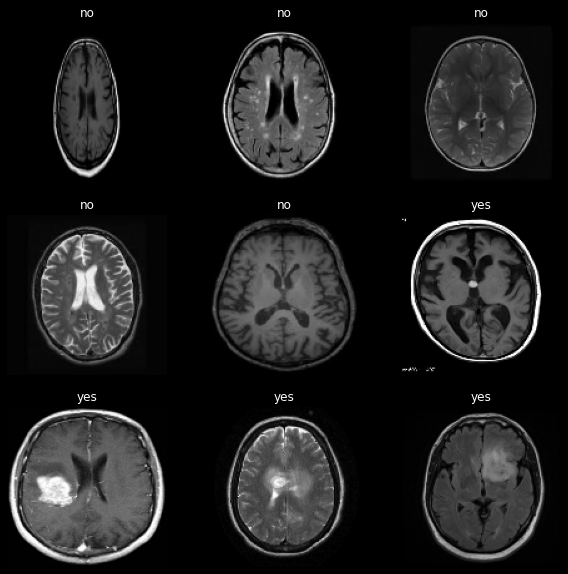

In [147]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.where(labels[i] == 1)[0][0]],color='white')
    plt.axis("off")

**Train and Test Data**




## **Create model**

In [148]:

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten,Rescaling,RandomFlip,RandomRotation

In [149]:
data_augmentation =  keras.Sequential(
    [
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
    ]
)

In [150]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [151]:
results = model.evaluate(train_ds, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0855


In [152]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [153]:

inputs = Input(shape=(128, 128, 3))

da = data_augmentation(inputs)

conv2d_layer = Conv2D(32, (2,2),strides=(1,1), padding='Same')(da)# Camada convolucional

conv2d_layer = Conv2D(32, (2,2), activation='relu',strides=(1,1), padding='Same')(conv2d_layer)# Camada convolucional

bn_layer = BatchNormalization()(conv2d_layer) # Normalização
mp_layer = MaxPooling2D(pool_size=(2,2))(bn_layer)# Redução de dimensionalidade
drop = Dropout(0.25)(mp_layer) # Regularização

conv2d_layer = Conv2D(64, (2,2), activation='relu',strides=(1,1), padding='Same')(drop)# Camada convolucional
conv2d_layer = Conv2D(64, (2,2), activation='relu',strides=(1,1), padding='Same')(conv2d_layer)# Camada convolucional

bn_layer = BatchNormalization()(conv2d_layer) # Normalização
mp_layer = MaxPooling2D(pool_size=(2,2), strides=(2,2))(bn_layer)# Redução de dimensionalidade
drop = Dropout(0.25)(mp_layer) # Regularização

flatten_layer = Flatten()(drop) # 

dense_layer = Dense(512, activation='relu')(flatten_layer)# Camada densa
drop = Dropout(0.5)(dense_layer) # Regularização
outputs = Dense(2, activation='softmax')(drop)# Camada densa

model = Model(inputs=inputs, outputs=outputs, name='tumor_model')
model.summary()

Model: "tumor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 conv2d_56 (Conv2D)          (None, 128, 128, 32)      416       
                                                                 
 conv2d_57 (Conv2D)          (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization_28 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                  

## **Fit Model**

In [154]:
model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=METRICS
              )

In [155]:
EPOCHS = 60

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_prc', 
#     verbose=1,
#     patience=10,
#     mode='max',
#     restore_best_weights=True)

history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    # callbacks=[early_stopping]
                    )

Epoch 1/100
1/1 [==============================] - 12s 12s/step - loss: 1.5086 - tp: 67.0000 - fp: 58.0000 - tn: 67.0000 - fn: 58.0000 - accuracy: 0.5360 - precision: 0.5360 - recall: 0.5360 - auc: 0.5234 - prc: 0.5242 - val_loss: 199.9945 - val_tp: 9.0000 - val_fp: 4.0000 - val_tn: 9.0000 - val_fn: 4.0000 - val_accuracy: 0.6923 - val_precision: 0.6923 - val_recall: 0.6923 - val_auc: 0.6923 - val_prc: 0.6560
Epoch 2/100
1/1 [==============================] - 8s 8s/step - loss: 39.5076 - tp: 92.0000 - fp: 33.0000 - tn: 92.0000 - fn: 33.0000 - accuracy: 0.7360 - precision: 0.7360 - recall: 0.7360 - auc: 0.7413 - prc: 0.7031 - val_loss: 45.6920 - val_tp: 10.0000 - val_fp: 3.0000 - val_tn: 10.0000 - val_fn: 3.0000 - val_accuracy: 0.7692 - val_precision: 0.7692 - val_recall: 0.7692 - val_auc: 0.7692 - val_prc: 0.7311
Epoch 3/100
1/1 [==============================] - 8s 8s/step - loss: 27.5335 - tp: 87.0000 - fp: 38.0000 - tn: 87.0000 - fn: 38.0000 - accuracy: 0.6960 - precision: 0.6960 - r

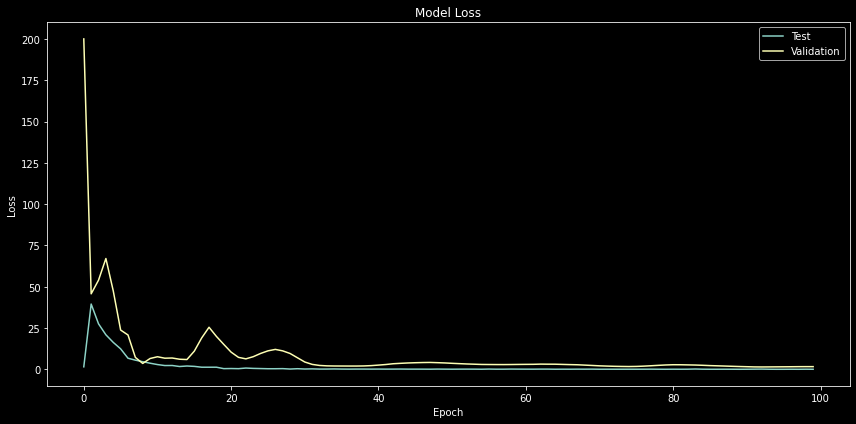

In [156]:
plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.tight_layout()

## **Test Model**

In [157]:
def classificacao_tumor(number):
    if number==1:
        return 'É um tumor'
    else:
        return 'Não é um tumor'

Confiança: 99.99994039535522% 
É um tumor


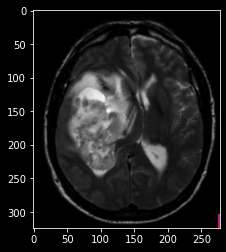

In [158]:

from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/MyDrive/GitHub/deteccao-tumores-tensorflow/Dados/Test/Y259.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print('Confiança: '+str(res[0][classification]*100) +'% \n'+ classificacao_tumor(classification))


Confiança: 99.97808337211609% 
Não é um tumor


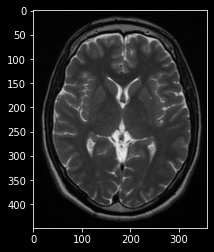

In [159]:
img = Image.open(r"/content/drive/MyDrive/GitHub/deteccao-tumores-tensorflow/Dados/Test/No22.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print('Confiança: '+str(res[0][classification]*100) + '% \n' + classificacao_tumor(classification))